## Import Packages

In [45]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set figure size for plots
rcParams['figure.figsize'] = 12, 6

## Model Selection and Training

In [51]:
data_file_path = '../data/preprocessed/avg_oil_pricing.csv'
preprocessed_data_dir_path = '../data/preprocessed'

ts_column = 'avg_oil_pricing'

data = pd.read_csv(data_file_path, parse_dates=['date'], index_col='date')

ts_diff = np.load(os.path.join(preprocessed_data_dir_path, 'pricing_diff.npy'))
ts_seasonal_diff = np.load(os.path.join(preprocessed_data_dir_path, 'pricing_seasonal_diff.npy'))

**Model Selection**: determining appropriate values for p, d, and q. This is typically done by analyzing the ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots.

- **p**: order of the AR term - *number of lagged observations*
- **q**: the degree of differencing -*number of times the data is differencing*
- **r**: the order of the MA term - *size of the moving average window*

### Parameter optimization
Grid search and information criteria

In [52]:
def optimize_arima_parameters(timeseries, p_range, d_range, q_range):
    best_aic = float("inf")
    best_params = None
    best_model = None

    total_iterations = len(p_range) * len(d_range) * len(q_range)
    print(f"Testing {total_iterations} ARIMA configurations")

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(timeseries, order=(p, d, q))
                    results = model.fit()

                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q)
                        best_model = results
                        print(f"ARIMA({p},{d},{q}) - AIC: {results.aic}")
                except:
                    continue
    print(f"\nBest ARIMA{best_params} model - AIC: {best_aic}")
    return best_model, best_params

In [53]:
non_seasonal_arima, params = optimize_arima_parameters(
    ts_diff, 
    p_range=range(0, 6),
    d_range=range(0, 2), 
    q_range=range(0, 6) 
)

Testing 72 ARIMA configurations
ARIMA(0,0,0) - AIC: -345.2274349181447
ARIMA(0,0,1) - AIC: -348.1537352466131
ARIMA(0,0,2) - AIC: -363.16166197478015
ARIMA(2,0,0) - AIC: -364.15532303788706
ARIMA(3,0,4) - AIC: -364.3029175948842
ARIMA(4,0,4) - AIC: -365.47851807651386

Best ARIMA(4, 0, 4) model - AIC: -365.47851807651386


In [35]:
seasonal_arima, params = optimize_arima_parameters(
    ts_seasonal_diff, 
    p_range=range(0, 6),
    d_range=range(0, 2), 
    q_range=range(0, 6) 
)

Testing 72 ARIMA configurations
ARIMA(0,0,0) - AIC: 125.65113371956694
ARIMA(0,0,1) - AIC: -21.133290732798077
ARIMA(0,0,2) - AIC: -123.17158613402086
ARIMA(0,0,3) - AIC: -166.36058659655424
ARIMA(0,0,4) - AIC: -200.9958206410775
ARIMA(0,0,5) - AIC: -221.6864546523523
ARIMA(0,1,0) - AIC: -233.4286973557341
ARIMA(0,1,1) - AIC: -236.6258995348067
ARIMA(0,1,2) - AIC: -251.98409563775465
ARIMA(0,1,4) - AIC: -262.32157851132206
ARIMA(0,1,5) - AIC: -262.64796147891377
ARIMA(1,0,4) - AIC: -264.27370760167594
ARIMA(1,0,5) - AIC: -266.75492878281443
ARIMA(1,1,5) - AIC: -266.87232511053
ARIMA(2,0,4) - AIC: -268.4996456984548
ARIMA(4,0,4) - AIC: -271.38711015465606
ARIMA(4,0,5) - AIC: -272.15506235702026
ARIMA(5,0,4) - AIC: -273.41467508963353

Best ARIMA(5, 0, 4) model - AIC: -273.41467508963353


While **not strictly required**, normally distributed residuals are generally desirable for certain statistical tests and inferences

In [6]:
def validate_model(model):
    residuals = pd.DataFrame(model.resid)
    
    plt.figure(figsize=(14, 7))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(14, 7))
    residuals.plot(kind='kde')
    plt.title('Residuals Density Plot')
    plt.grid(True)
    plt.show()
    
    print("Residuals Summary Statistics:")
    print(residuals.describe())
    
    # Perform Ljung-Box test to check for autocorrelation in residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(residuals, lags=10)
    
    print("\nLjung-Box Test Results:")
    print(pd.DataFrame({
        'Test Statistic': lb_test['lb_stat'],
        'p-value': lb_test['lb_pvalue']
    }))
    
    # Check for normality of residuals (Shapiro-Wilk test)
    shapiro_test = stats.shapiro(residuals)
    print("\nShapiro-Wilk Test for Normality:")
    print(f"Test Statistic: {shapiro_test[0]}")
    print(f"p-value: {shapiro_test[1]}")
    if shapiro_test[1] > 0.05:
        print("Residuals appear to be normally distributed")
    else:
        print("Residuals do not appear to be normally distributed")

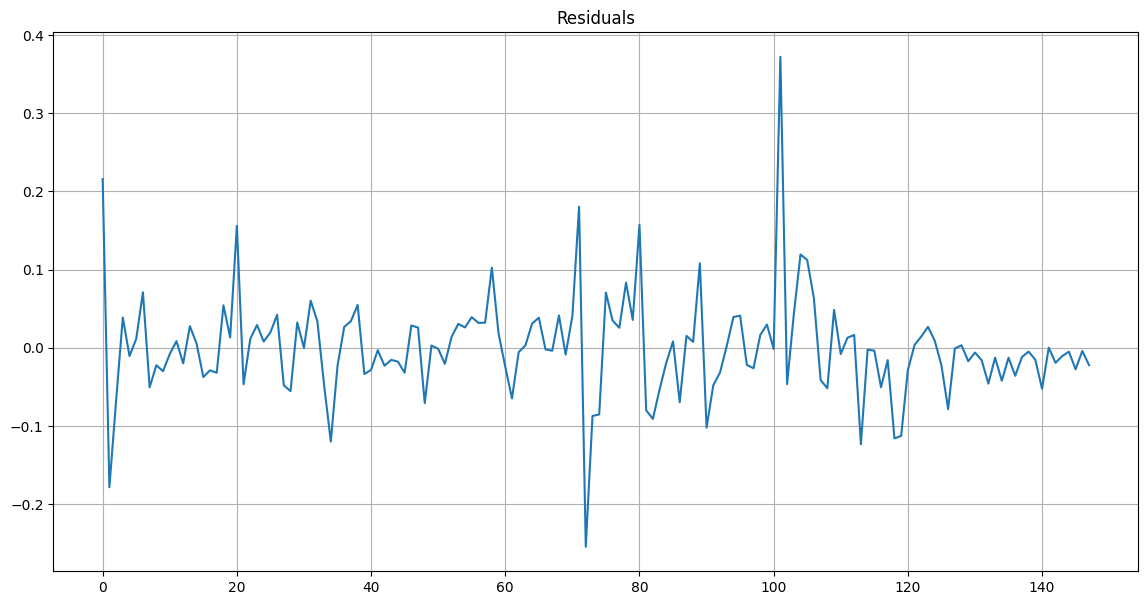

<Figure size 1400x700 with 0 Axes>

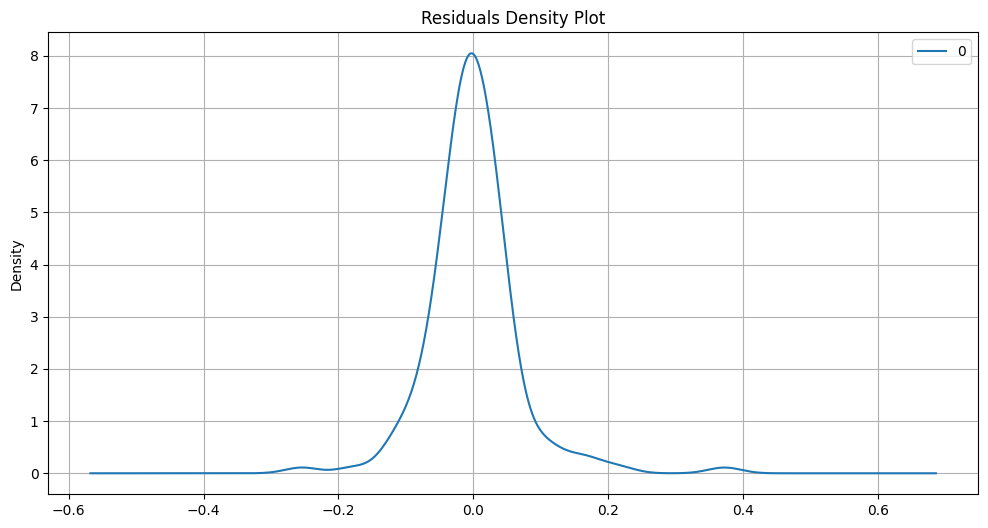

Residuals Summary Statistics:
                0
count  148.000000
mean    -0.000291
std      0.066621
min     -0.254402
25%     -0.028986
50%     -0.003303
75%      0.028737
max      0.372256

Ljung-Box Test Results:
    Test Statistic   p-value
1         0.019063  0.890185
2         0.020494  0.989805
3         0.039145  0.997964
4         0.347301  0.986560
5         1.017819  0.961116
6         1.880295  0.930372
7         1.937232  0.963233
8         2.346713  0.968496
9         3.161201  0.957559
10        3.198644  0.976355

Shapiro-Wilk Test for Normality:
Test Statistic: 0.8788907935253946
p-value: 1.2051227212191637e-09
Residuals do not appear to be normally distributed


In [16]:
validate_model(non_seasonal_arima)

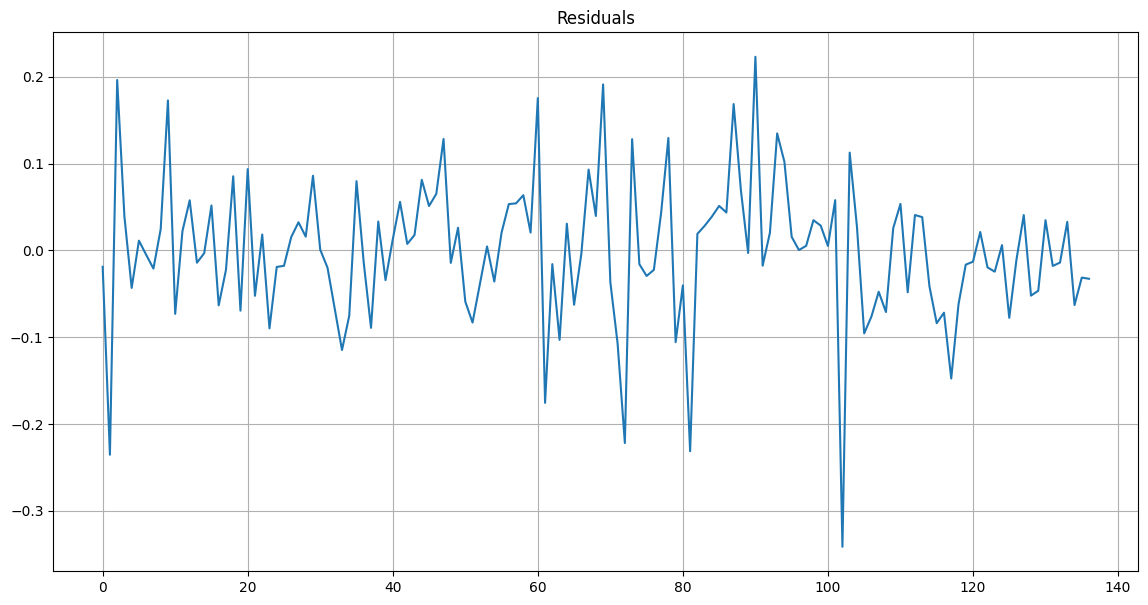

<Figure size 1400x700 with 0 Axes>

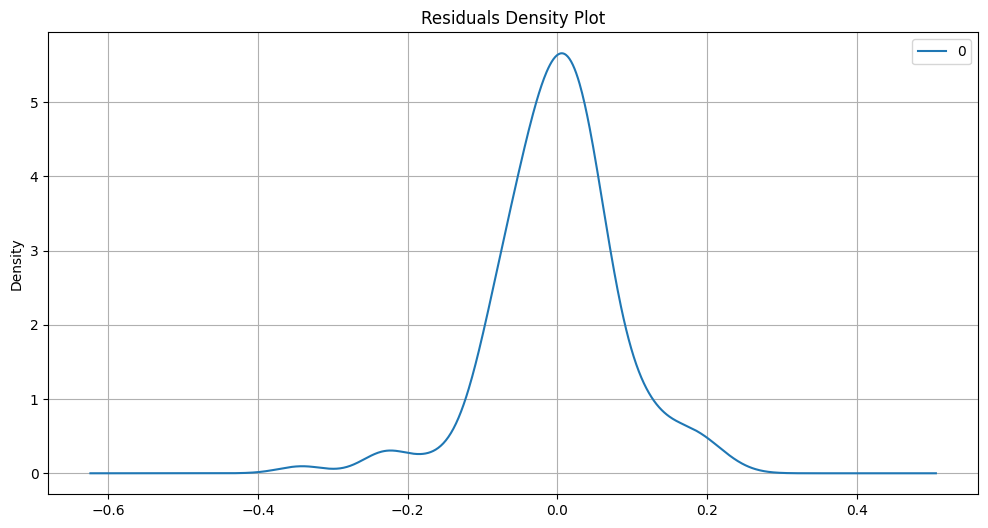

Residuals Summary Statistics:
                0
count  137.000000
mean    -0.000549
std      0.082487
min     -0.341546
25%     -0.041552
50%      0.000784
75%      0.039753
max      0.223218

Ljung-Box Test Results:
    Test Statistic   p-value
1         0.184419  0.667603
2         0.766415  0.681671
3         1.050138  0.789122
4         1.060363  0.900509
5         1.421098  0.921992
6         1.439766  0.963395
7         1.443106  0.984214
8         6.389489  0.603690
9        14.881544  0.094242
10       15.282201  0.122107

Shapiro-Wilk Test for Normality:
Test Statistic: 0.9525655138834023
p-value: 0.00011687028995843733
Residuals do not appear to be normally distributed


In [17]:
validate_model(seasonal_arima)

Missing values before handling: avg_oil_pricing    0
dtype: int64
Missing values after handling: avg_oil_pricing    0
dtype: int64
top 5 predictions:                 Actual   Predicted
date                              
2023-03-30  343.333333  369.619659
2023-05-01  305.111111  334.838739
2023-06-01  279.555556  331.715856
2023-07-01  277.888889  321.481043
2023-08-01  272.555556  294.850257

last 5 predictions:                 Actual   Predicted
date                              
2024-12-01  253.222222  169.473582
2024-12-05  253.777778  166.021415
2025-01-01  252.666667  162.728695
2025-02-01  254.666667  160.107744
2025-04-01  252.444444  157.503894


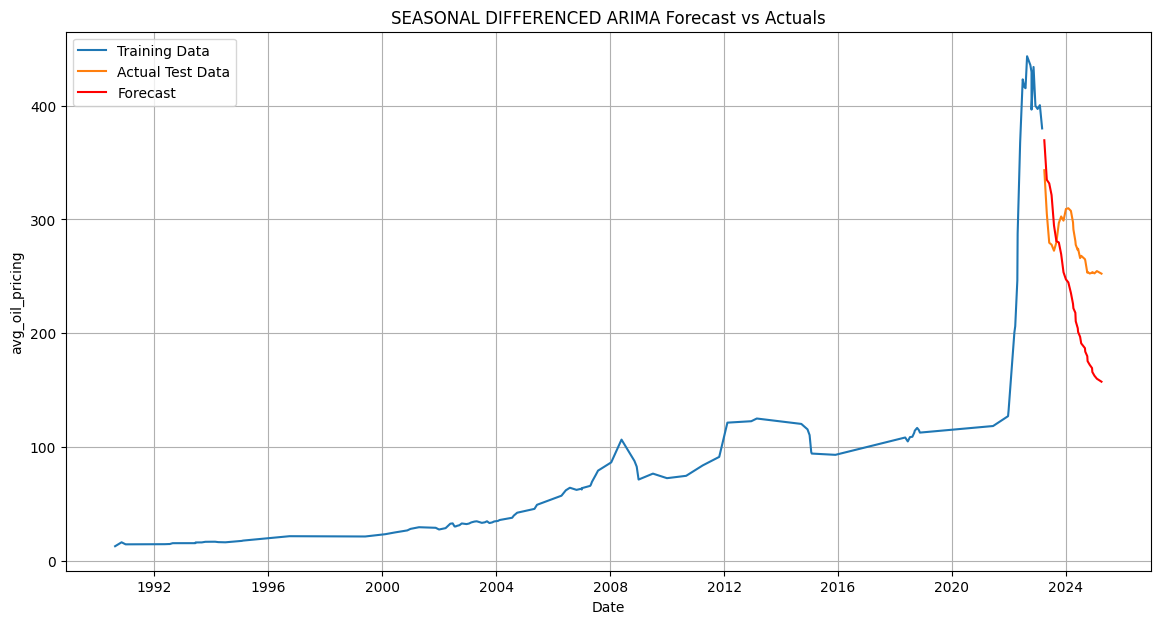

Mean Squared Error (MSE): 4461.174847487759
Root Mean Squared Error (RMSE): 66.79202682572044
Mean Absolute Error (MAE): 62.32527377109014
Mean Absolute Percentage Error (MAPE): 22.897256270579184%


In [40]:
def handle_missing_values(data):
    missing_values = data.isnull().sum()
    print(f"Missing values before handling: {missing_values}")
    
    # Forward fill
    # data_ffill = data.fillna(method='ffill')
    
    # Backward fill
    # data_bfill = data.fillna(method='bfill')
    
    # Linear interpolation
    #  data_interp = data.interpolate(method='linear')
    
    # Time-based interpolation
    data_time_interp = data.interpolate(method='time')
    missing_values = data_time_interp.isnull().sum()
    print(f"Missing values after handling: {missing_values}")
    return data_time_interp

def test_arima_on_holdout(data, column_name, train_size=0.8, order=(1, 0, 1), seasonality='SEASONAL'):
    train_size = int(len(data) * train_size)
    train, test = data[:train_size], data[train_size:]
    
    model = ARIMA(train[column_name], order=order)
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=len(test))
    results = pd.DataFrame({
        'Actual': test[column_name].values,
        'Predicted': forecast.values
    }, index=test.index)
    
    print('top 5 predictions:', results.head())
    print()
    print('last 5 predictions:', results.tail())
    # Plot actual vs forecast
    plt.figure(figsize=(14, 7))
    plt.plot(train[column_name], label='Training Data')
    plt.plot(test.index, results['Actual'], label='Actual Test Data')
    plt.plot(test.index, results['Predicted'], label='Forecast', color='red')
    plt.title(f'{seasonality} DIFFERENCED ARIMA Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    rmse = sqrt(mse)
    mae = mean_absolute_error(results['Actual'], results['Predicted'])
    mape = np.mean(np.abs((results['Actual'] - results['Predicted']) / results['Actual'])) * 100
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
    return results, model_fit

data_missing_values_handled = handle_missing_values(data)
results, model_fit = test_arima_on_holdout(data_missing_values_handled, ts_column, order = (4, 0, 4))

Missing values before handling: avg_oil_pricing    0
dtype: int64
Missing values after handling: avg_oil_pricing    0
dtype: int64
top 5 predictions:                 Actual   Predicted
date                              
2023-03-30  343.333333  353.032417
2023-05-01  305.111111  326.753017
2023-06-01  279.555556  311.624627
2023-07-01  277.888889  280.553536
2023-08-01  272.555556  269.296763

last 5 predictions:                 Actual   Predicted
date                              
2024-12-01  253.222222  184.445946
2024-12-05  253.777778  181.511846
2025-01-01  252.666667  178.712300
2025-02-01  254.666667  175.998351
2025-04-01  252.444444  173.369214


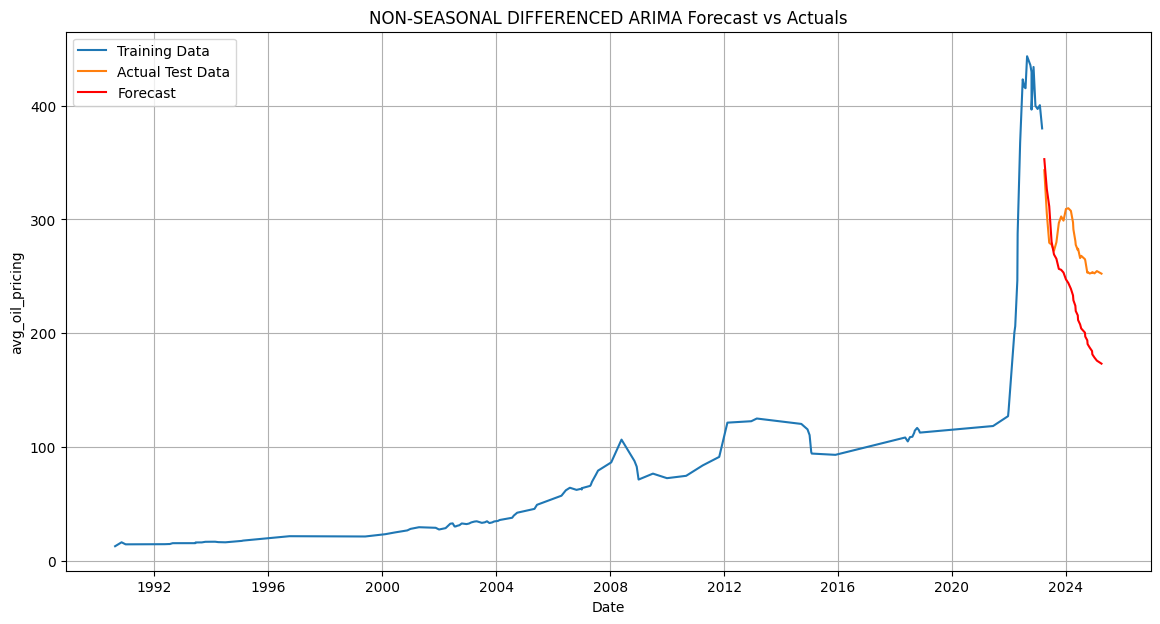

Mean Squared Error (MSE): 3270.790833192474
Root Mean Squared Error (RMSE): 57.19082822614544
Mean Absolute Error (MAE): 52.93970651885943
Mean Absolute Percentage Error (MAPE): 19.37069496780199%


In [42]:
data_missing_values_handled = handle_missing_values(data)
results, model_fit = test_arima_on_holdout(data_missing_values_handled, ts_column, order = (5, 0, 4), seasonality='NON-SEASONAL')

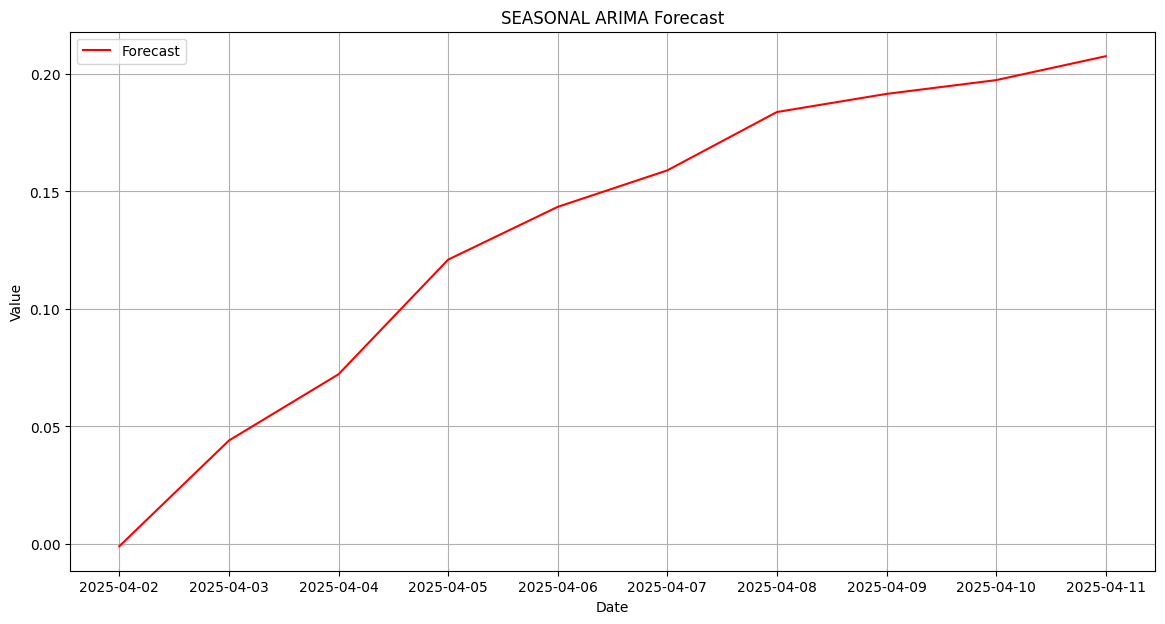

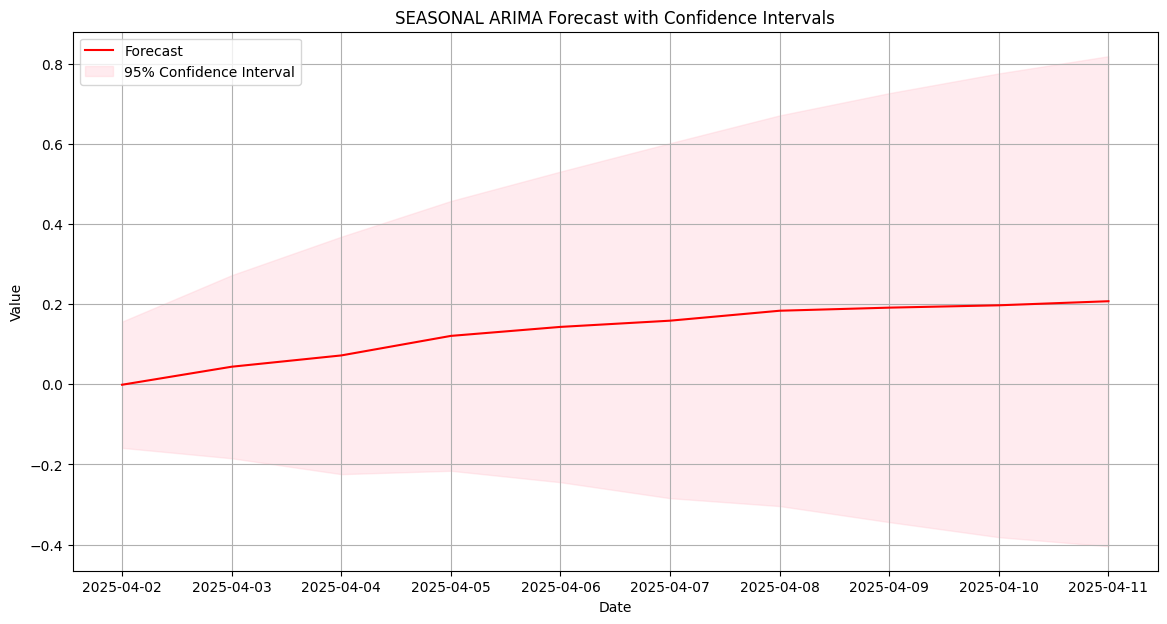

,Forecast,Lower CI,Upper CI
2025-04-02,-0.000948,-0.158508,0.156611
2025-04-03,0.044024,-0.184530,0.272578
2025-04-04,0.072219,-0.224164,0.368603
2025-04-05,0.120988,-0.215790,0.457767
2025-04-06,0.143449,-0.244323,0.531221


In [43]:
def forecast_future(
        model, 
        steps, 
        original_index, 
        frequency='D',  # daily (M for monthly),
        seasonality='SEASONAL'
    ): 
    forecast = model.forecast(steps=steps)
    last_date = original_index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq=frequency)
    forecast_df = pd.DataFrame(
        {
            'Forecast': forecast
        }, 
        index=forecast_dates
    )
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.title(f'{seasonality} ARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    pred_conf = model.get_forecast(steps=steps).conf_int()
    lower_conf = pred_conf[:, 0]
    upper_conf = pred_conf[:, 1]
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index,
        lower_conf,
        upper_conf,
        color='pink', 
        alpha=0.3, 
        label='95% Confidence Interval'
    )
    plt.title(f'{seasonality} ARIMA Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    forecast_df['Lower CI'] = lower_conf
    forecast_df['Upper CI'] = upper_conf
    return forecast_df

forecast_df = forecast_future(seasonal_arima, 10, data.index)
forecast_df.head()

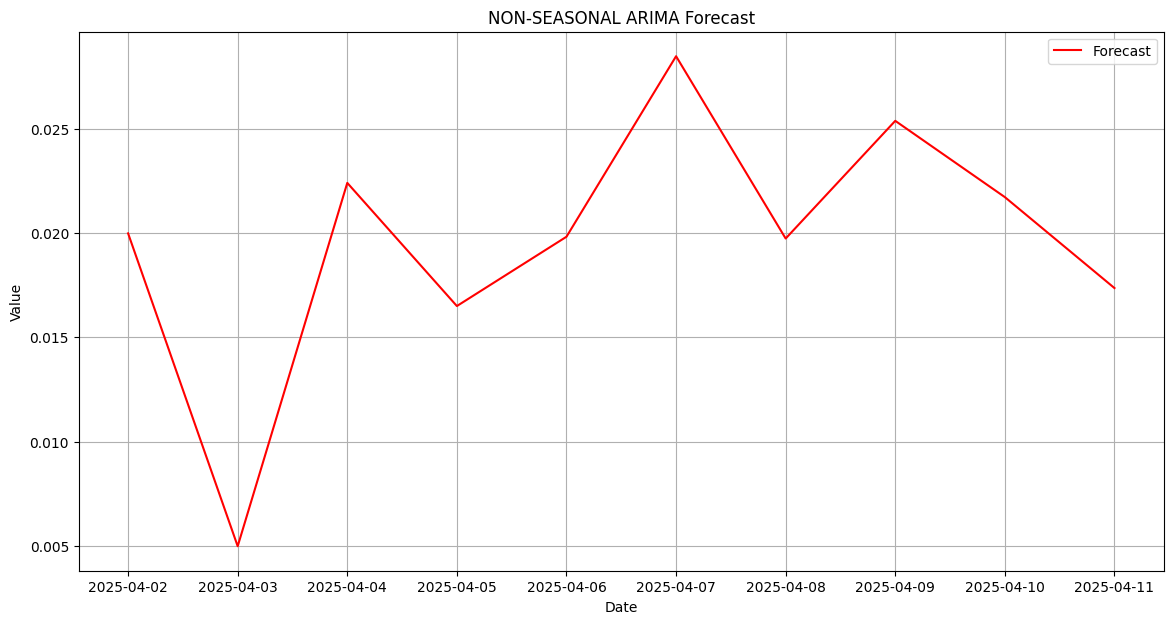

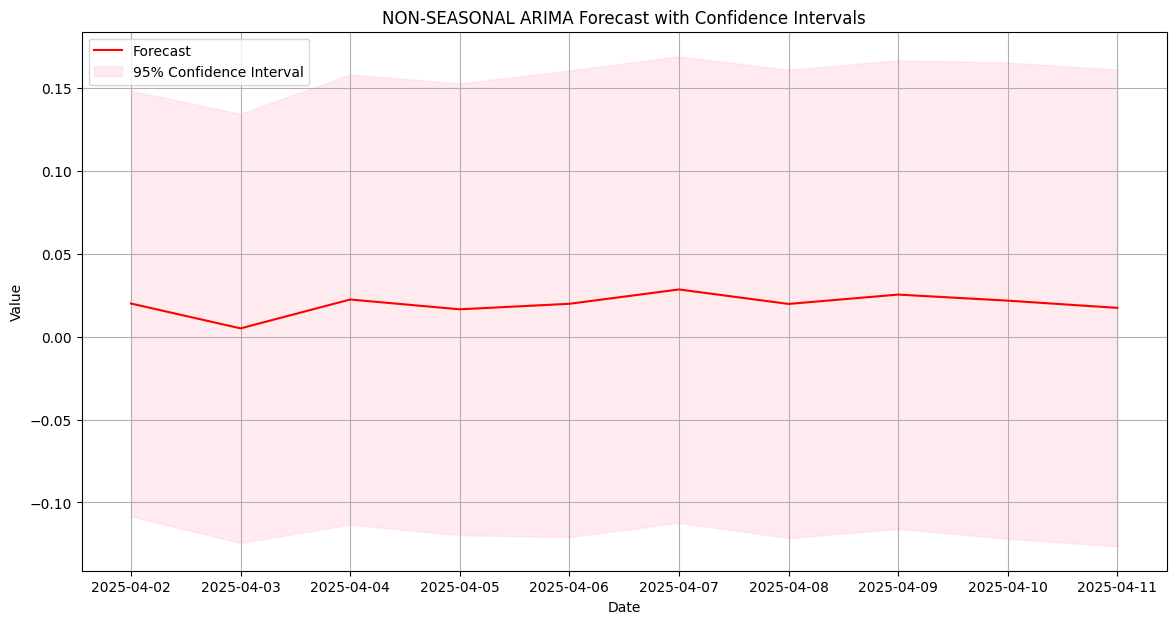

,Forecast,Lower CI,Upper CI
2025-04-02,0.019976,-0.108403,0.148354
2025-04-03,0.004984,-0.124452,0.134420
2025-04-04,0.022394,-0.113382,0.158169
2025-04-05,0.016493,-0.119744,0.152730
2025-04-06,0.019814,-0.120890,0.160517


In [44]:
forecast_df = forecast_future(non_seasonal_arima, 10, data.index, seasonality='NON-SEASONAL')
forecast_df.head()

## Seasonal ARIMA (SARIMA)

Extends ARIMA to handle seasonal components. The model is denoted as `SARIMA(p,d,q)(P,D,Q,s)` where:<br>
- `p,d,q`: Non seasonal components
- `P,D,Q`: Seasonal components
- `s`: Seasonality period (eg. 12 for monthly data)

Missing values before handling: avg_oil_pricing    0
dtype: int64
Missing values after handling: avg_oil_pricing    0
dtype: int64
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  148
Model:             SARIMAX(5, 0, 4)x(5, 0, 4, 12)   Log Likelihood                 191.587
Date:                            Thu, 05 Jun 2025   AIC                           -345.175
Time:                                    12:40:16   BIC                           -288.228
Sample:                                         0   HQIC                          -322.037
                                            - 148                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

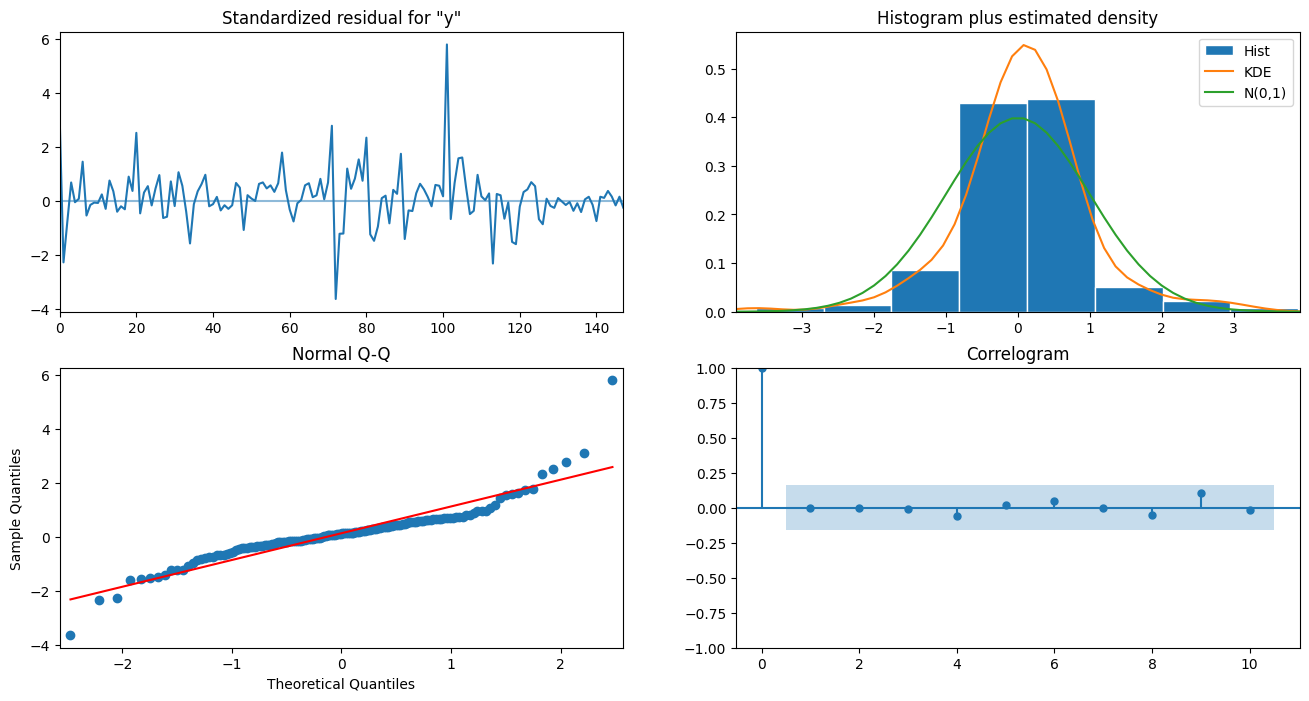

In [76]:
def fit_sarima_model(endog, order, seasonal_order):
    model = SARIMAX(endog, order=order, seasonal_order=seasonal_order)

    results = model.fit()
    print(results.summary())

    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    return model

data_missing_values_handled = handle_missing_values(data)
sarima = fit_sarima_model(
    endog=ts_diff, 
    # exog=data_missing_values_handled['temperature'], 
    order=(5, 0, 4), 
    seasonal_order=(5, 0, 4, 12)
)

In [3]:
def optimize_sarimax_parameters(timeseries, p, d, q, P_range, D_range, Q_range, s):
    best_aic = float("inf")
    best_params = None
    best_model = None
    
    total_iterations = len(P_range) * len(D_range) * len(Q_range)
    print(f"Testing {total_iterations} SARIMAX configurations with seasonal={s}")
    
    counter = 0
    for P in P_range:
        for D in D_range:
            for Q in Q_range:
                counter += 1
                if counter % 10 == 0:
                    print(f"Progress: {counter}/{total_iterations} configurations tested")
                    
                # Skip if all parameters are 0
                if p + d + q + P + D + Q == 0:
                    continue
                    
                try:
                    model = SARIMAX(
                        timeseries,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    results = model.fit(disp=False, maxiter=200)
                    
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q, P, D, Q, s)
                        best_model = results
                        print(f"SARIMA({p},{d},{q})({P},{D},{Q},{s}) - AIC: {results.aic:.4f}")
                except:
                    continue
    
    if best_model is not None:
        print(f"\nBest SARIMA{best_params} model - AIC: {best_aic:.4f}")
    else:
        print("No suitable SARIMAX model found.")
        
    return best_model, best_params

sarima, params = optimize_sarimax_parameters(
    ts_diff,
    p=4, 
    d=0, 
    q=4, 
    P_range=range(0, 6), 
    D_range=range(0, 2), 
    Q_range=range(0, 6), 
    s=12
)

Testing 72 SARIMAX configurations with seasonal=12
SARIMA(4,0,4)(0,0,0,12) - AIC: -360.6369
Progress: 10/72 configurations tested
Progress: 20/72 configurations tested
Progress: 30/72 configurations tested
Progress: 40/72 configurations tested
Progress: 50/72 configurations tested
Progress: 60/72 configurations tested
Progress: 70/72 configurations tested

Best SARIMA(4, 0, 4, 0, 0, 0, 12) model - AIC: -360.6369


In [ ]:
# sarimax = SARIMAX(
#     ts_diff,
#     order=(4, 0, 4),
#     seasonal_order=(0, 0, 0, 12),
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )
# sarima = sarimax.fit(disp=False, maxiter=200)
# sarima.aic

np.float64(-360.6368571293425)

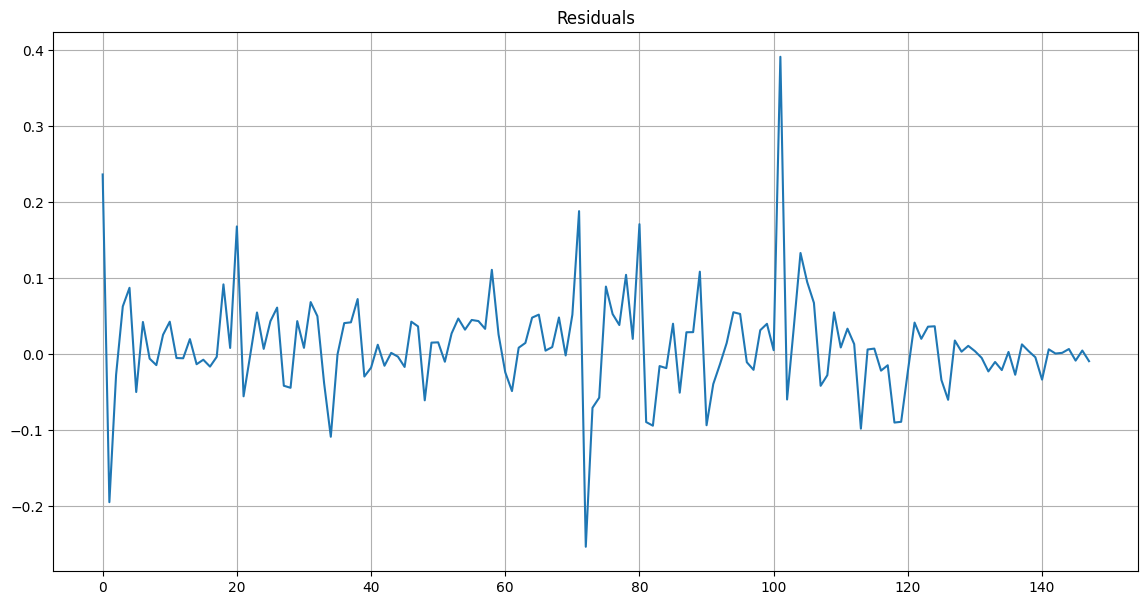

<Figure size 1400x700 with 0 Axes>

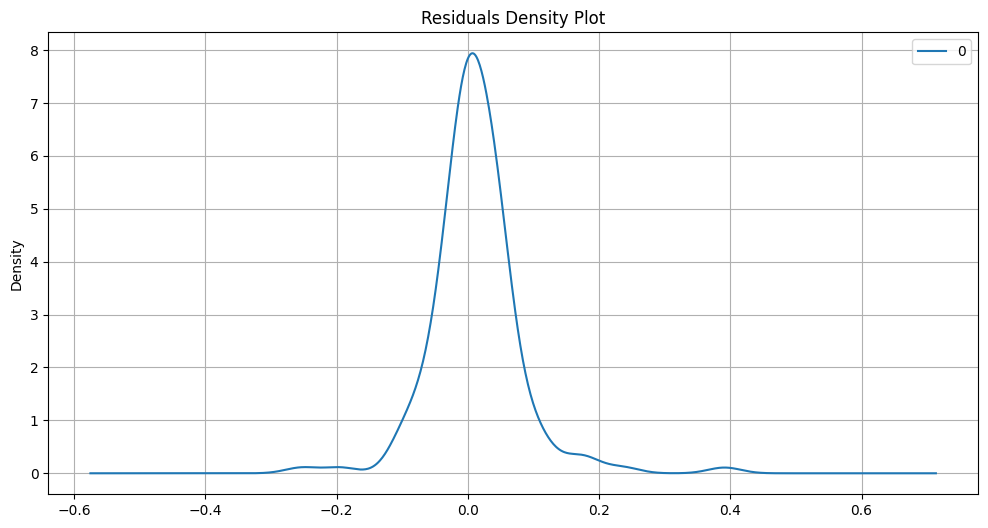

Residuals Summary Statistics:
                0
count  148.000000
mean     0.011814
std      0.067624
min     -0.253213
25%     -0.017013
50%      0.006895
75%      0.041646
max      0.391041

Ljung-Box Test Results:
    Test Statistic   p-value
1         0.684394  0.408078
2         0.962287  0.618076
3         1.039110  0.791790
4         1.139925  0.887887
5         1.404632  0.923806
6         1.940804  0.925061
7         1.952871  0.962403
8         3.325731  0.912286
9         4.636654  0.864763
10        4.649273  0.913343

Shapiro-Wilk Test for Normality:
Test Statistic: 0.8726167384555356
p-value: 5.940187109043955e-10
Residuals do not appear to be normally distributed


In [21]:
validate_model(sarima)

Missing values before handling: avg_oil_pricing    0
dtype: int64
Missing values after handling: avg_oil_pricing    0
dtype: int64


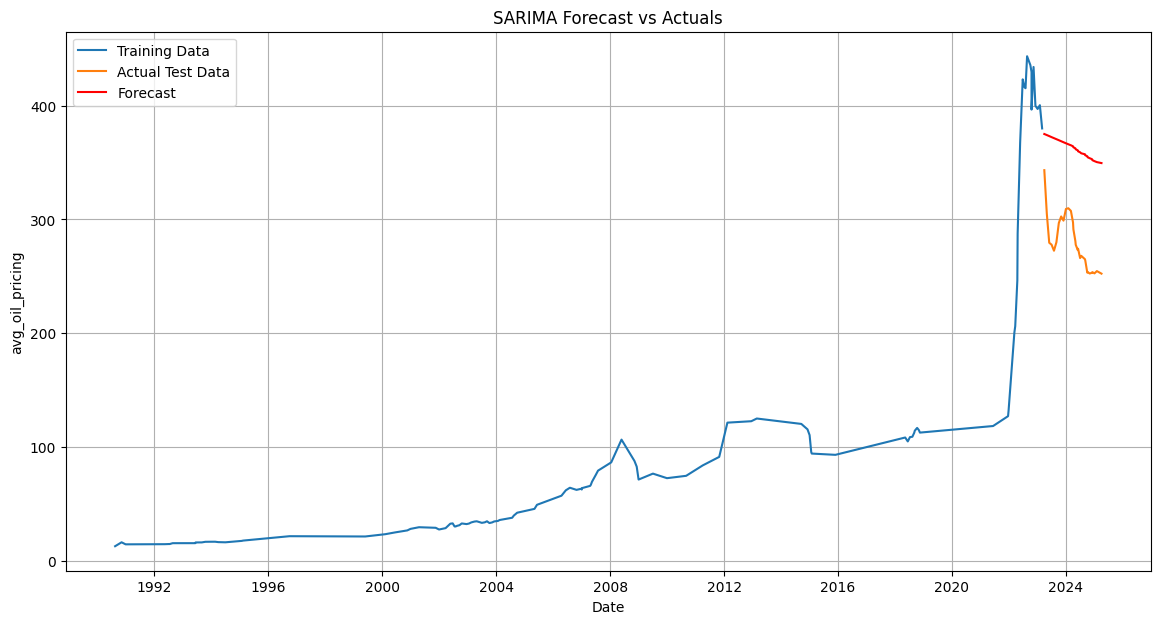

Mean Squared Error (MSE): 7221.269854037386
Root Mean Squared Error (RMSE): 84.97805513211858
Mean Absolute Error (MAE): 83.2268275773211
Mean Absolute Percentage Error (MAPE): 30.477816359532884%


In [22]:
def test_sarima_on_holdout(data, column_name, train_size=0.8, order=(1, 0, 1), seasonal_order=(2, 0, 3, 12)):
    train_size = int(len(data) * train_size)
    train, test = data[:train_size], data[train_size:]
    
    model = SARIMAX(train[column_name], order=order)
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=len(test))
    results = pd.DataFrame({
        'Actual': test[column_name].values,
        'Predicted': forecast.values
    }, index=test.index)
    
    # Plot actual vs forecast
    plt.figure(figsize=(14, 7))
    plt.plot(train[column_name], label='Training Data')
    plt.plot(test.index, results['Actual'], label='Actual Test Data')
    plt.plot(test.index, results['Predicted'], label='Forecast', color='red')
    plt.title('SARIMA Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    rmse = sqrt(mse)
    mae = mean_absolute_error(results['Actual'], results['Predicted'])
    mape = np.mean(np.abs((results['Actual'] - results['Predicted']) / results['Actual'])) * 100
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
    return results, model_fit

data_missing_values_handled = handle_missing_values(data)
results, model_fit = test_sarima_on_holdout(data_missing_values_handled, ts_column)

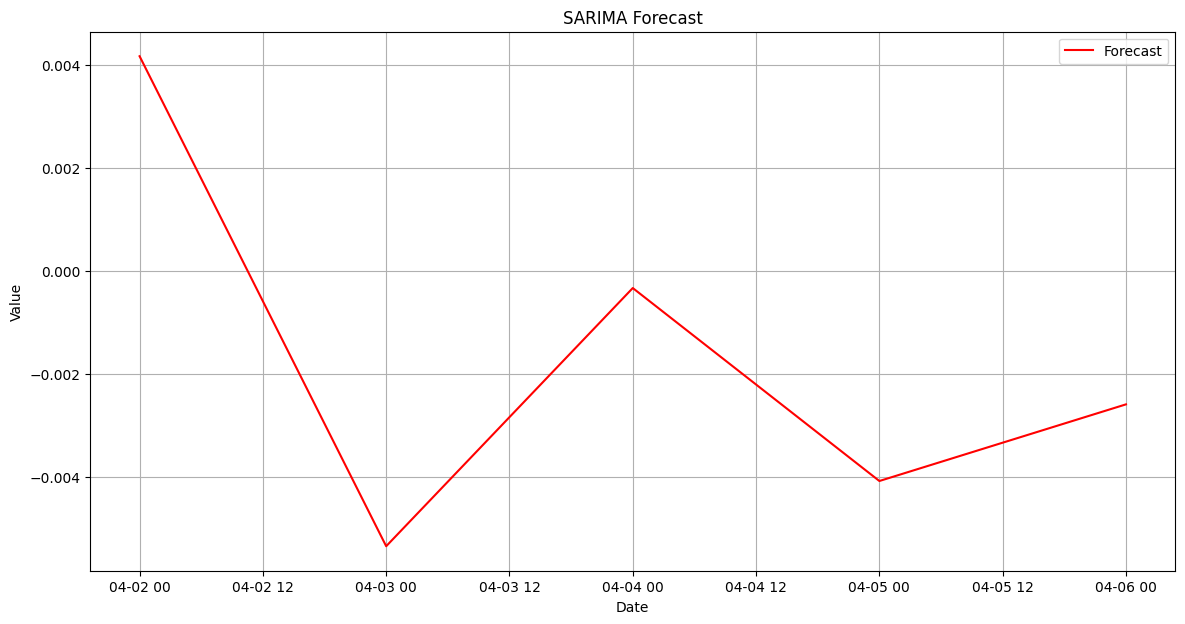

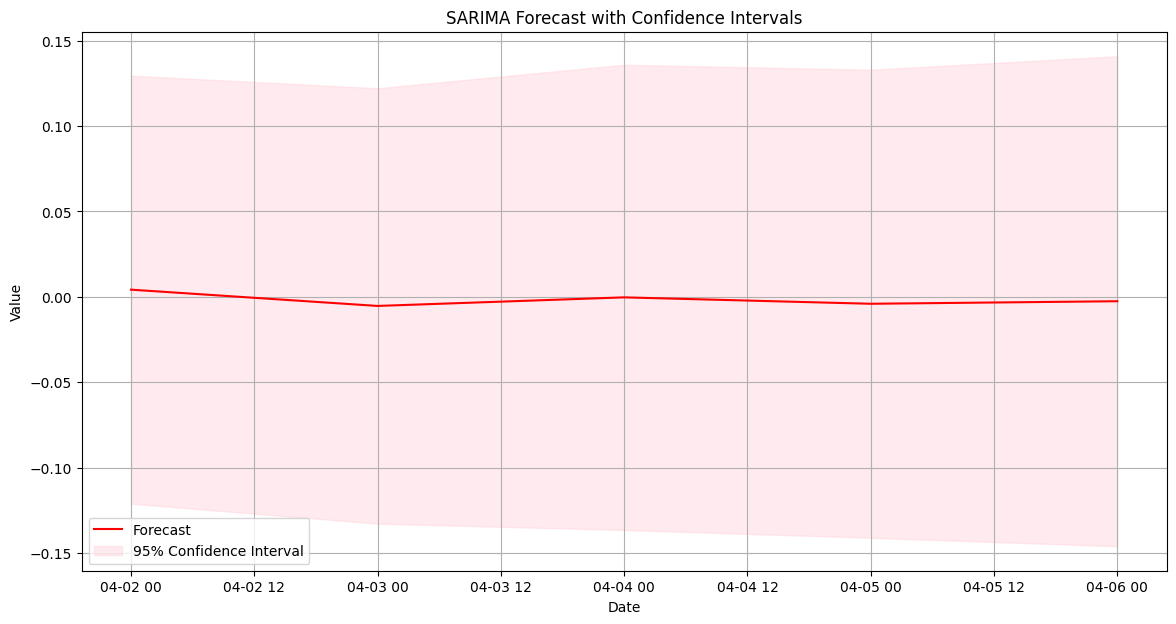

,Forecast,Lower CI,Upper CI
2025-04-02,0.004176,-0.121130,0.129482
2025-04-03,-0.005356,-0.132836,0.122125
2025-04-04,-0.000334,-0.136541,0.135873
2025-04-05,-0.004087,-0.141118,0.132944
2025-04-06,-0.002596,-0.146063,0.140870


In [26]:
def forecast_future(
        model, 
        steps, 
        original_index, 
        frequency='D'  # daily (M for monthly)
    ): 
    forecast = model.forecast(steps=steps)
    last_date = original_index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq=frequency)
    forecast_df = pd.DataFrame(
        {
            'Forecast': forecast
        }, 
        index=forecast_dates
    )
    plt.figure(figsize=(14, 7))

    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.title('SARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    pred_conf = model.get_forecast(steps=steps).conf_int()
    lower_conf = pred_conf[:, 0]
    upper_conf = pred_conf[:, 1]
    plt.figure(figsize=(14, 7))

    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index,
        lower_conf,
        upper_conf,
        color='pink', 
        alpha=0.3, 
        label='95% Confidence Interval'
    )
    plt.title('SARIMA Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    forecast_df['Lower CI'] = lower_conf
    forecast_df['Upper CI'] = upper_conf
    return forecast_df

forecast_df = forecast_future(sarima, 5, data.index)
forecast_df.head()

### Final thought

- Best ARIMA (with seasonally non differenced data): `p=5, d=0, q=4`
- Best ARIMA (with seasonally differenced data): `p=4, d=0, q=4`
- Best SARIMA: `p=5, d=0, q=4, P=0, D=0, Q=0, s=12`